In [1]:
import os
import pprint
from time import time
import threading
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.cross_validation import cross_val_score
from matplotlib.ticker import NullFormatter
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

class Data:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.labels = None

    def load_data(self, train_rows=None, test_rows=None, shfl=False, scl=True):
        data_folder = os.path.join("../", "data")
        X_train_file_path = os.path.join(data_folder, "Train/X_train.txt")
        y_train_file_path = os.path.join(data_folder, "Train/y_train.txt")
        X_test_file_path = os.path.join(data_folder, "Test/X_test.txt")
        y_test_file_path = os.path.join(data_folder, "Test/y_test.txt")
        labels_file_path = os.path.join(data_folder, "activity_labels.txt")
        self.X_train = np.loadtxt(X_train_file_path, delimiter=' ')[
                       0:train_rows, :]
        self.y_train = np.loadtxt(y_train_file_path, delimiter=' ')[
                       0:train_rows, ]
        self.X_test = np.loadtxt(X_test_file_path, delimiter=' ')[0:test_rows,
                      :]
        self.y_test = np.loadtxt(y_test_file_path, delimiter=' ')[0:test_rows, ]
        lb = np.genfromtxt(labels_file_path, delimiter=' ', dtype=None)
        self.labels = np.asarray(map(lambda x: x[1], lb))
        if scl:
            StandardScaler().fit_transform(self.X_train)
        if shfl:
            self.X_train, self.y_train = shuffle(self.X_train, self.y_train)


class Classifiers:
    def __init__(self, data):
        self.X_train = data.X_train
        self.y_train = data.y_train
        self.X_test = data.X_test
        self.y_test = data.y_test
        self.y_predict = {}  # {k - name_of_classifier, v - [predictions]}
        self.cls = {}  # {k - name_of_classifier, v - sklearn_classifier_object}
        self.scores = {}  # {k - name_of_classifier, { k - score_metric,
        self.fit_time = {}
        self.predict_time = {}
        # v - score}}

    def add_classifier(self, classifier_name, classifier):
        self.cls[classifier_name] = classifier

    def __fit(self, cls, cls_name, X, y):
        t0 = time()
        cls.fit(X, y)
        t1 = time() - t0
        self.fit_time[cls_name] = t1 
        print("%s done in %0.3fs" % (cls_name, t1))

    def fit(self):
        threads = []
        for classifier_name, classifier in self.cls.items():
            th = threading.Thread(target=self.__fit, args=(
                classifier, classifier_name, self.X_train, self.y_train,))
            threads.append(th)
            th.start()

        for th in threads:
            th.join()
            
    def predict(self):
        for classifier_name, classifier in self.cls.items():
            start_time = time()
            self.y_predict[classifier_name] = classifier.predict(self.X_test)
            self.predict_time[classifier_name] = time() - start_time

    def get_scores(self):
        for classifier_name, classifier in self.cls.items():
            self.__get_score(classifier_name, classifier)

    def __get_score(self, classifier_name, classifier):
        self.scores[classifier_name] = {
            "accuracy": accuracy_score(self.y_test,
                                       self.y_predict[classifier_name]),
            "precision": precision_score(self.y_test,
                                         self.y_predict[classifier_name],
                                         average='weighted'),
            "recall": recall_score(self.y_test,
                                   self.y_predict[classifier_name],
                                   average='weighted')
        }

    def print_scores_sys(self):
        pprint.pprint(self.scores)

    def print_scores(self):
        df = pd.DataFrame(self.scores)
        display(df)

    def show_plt(self):
        cls_names = []
        accuracy = []
        precision = []
        recall = []
        for name, score_values in self.scores.items():
            cls_names.append(name)
            # print(score_values)
            for score_type, v in score_values.items():
                if score_type == 'accuracy':
                    accuracy.append(v)
                elif score_type == 'precision':
                    precision.append(v)
                elif score_type == 'recall':
                    recall.append(v)
        accuracy, cls_names = (list(t) for t in
                               zip(*sorted(zip(accuracy, cls_names))))
        plt.figure(figsize=(12,10))
        plt.barh(np.arange(len(cls_names)), accuracy, align='center', alpha=0.4)
        plt.yticks(np.arange(len(cls_names)), cls_names)
        plt.ylabel("Classifiers")
        plt.xlabel("Accuracy")
        plt.subplots_adjust(left=.3)
        plt.title("Accuracy vs. Classifiers")
        plt.show()
        
def pca():
    pca_values = [2, 5, 10, 25, 30, 40, 50, 100, 150, 200, 250, 300, 561]
    # pca_values = [561]
    scores = {}
    for v in pca_values:
        data = Data()
        # data.load_data(3000)
        data.load_data(shfl=True)
        print("############### Running PCA with %s components ###############" % v)
        pca = PCA(n_components=v)
        data.X_train = pca.fit_transform(data.X_train)
        data.X_test = pca.transform(data.X_test)
        cls = Classifiers(data)
        dtc = DecisionTreeClassifier()
        gnb = GaussianNB()
        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()
        linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
        poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
        rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
        knn = KNeighborsClassifier(12)
        rfc = RandomForestClassifier(n_estimators=10, max_features=0.8)
        cls.add_classifier("knn", knn)
        cls.add_classifier("decision-trees", dtc)
        cls.add_classifier("gaussian-naive-bayes", gnb)
        cls.add_classifier("linear-discriminant-analysis", lda)
        cls.add_classifier("quadratic-discriminant-analysis", qda)
        cls.add_classifier("linear-support-vector-machine", linear_svc)
        cls.add_classifier("poly-support-vector-machine", poly_svc)
        cls.add_classifier("rbf-support-vector-machine", rbf_svc)
        cls.add_classifier("random-forest", rfc)
        cls.fit()
        cls.predict()
        cls.get_scores()
        cls.print_scores()
        for k, v in cls.scores.items():
            try:
                scores[k] += [v["accuracy"]]
            except KeyError:
                scores[k] = [v["accuracy"]]
        #Creating PCA values vs Accuracy Graph
    for k, v in scores.items():
        plt.plot(pca_values, v, label=k)
    plt.xlabel("PCA Values")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=1, mode="expand", borderaxespad=0.)
    plt.show()


def train_time1():
    pca_values = [2, 5, 10, 25, 30, 40, 50, 100, 150, 200, 250, 300, 561]
    # Fitting time for each classifier graph
    fit_times = {
        "RBF": [0.975, 0.482, 0.520, 0.616, 0.638, 0.799, 0.933, 1.787, 2.535, 3.845, 5.046, 7.022, 15.602],
    "QDA": [0.024, 0.003, 0.004, 0.017, 0.019, 0.021, 0.030, 0.058, 0.093, 0.100, 0.152, 0.214, 0.863],
    "kNN": [0.008, 0.005, 0.006, 0.010, 0.011, 0.012, 0.015, 0.029, 0.041, 0.057, 0.075, 0.097, 0.368],
    "LDA": [0.027, 0.004, 0.005, 0.014, 0.015, 0.015, 0.024, 0.065, 0.078, 0.146, 0.216, 0.253, 0.680],
    "GNB":[0.025, 0.002, 0.002, 0.004, 0.004, 0.005, 0.006, 0.014, 0.020, 0.037, 0.039, 0.050, 0.115],
    "Decision Tree":[0.049, 0.047, 0.092, 0.246, 0.294, 0.409, 0.517, 1.091, 2.161, 2.374, 2.826, 3.580, 5.724],
    "poly SVM":[40.559, 1.734, 0.405, 0.380, 0.453, 1.090, 1.102, 4.681, 11.141, 21.451, 31.694, 49.976, 119.453],
    "linear SVM":[0.845, 0.296, 0.312, 0.316, 0.327, 0.629, 0.477, 0.696, 1.096, 1.167, 1.937, 2.006, 3.800]
    }
    for k, v in fit_times.items():
        plt.plot(pca_values, v, label=k)
    plt.xlabel("PCA Values")
    plt.ylabel("Fit Time")
    plt.title("Classifier vs Fitting Time")
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=1, mode="expand", borderaxespad=0.)

    for k, v in saved_scores.items():
    #     print(k, v)
        plt.plot(pca_values, v, label=k)
    plt.show()
        
def fit_predict_time():
    # Plotting the prediction time graph
    predict_time = {}

    data = Data()
    # data.load_data(3000)
    data.load_data(shfl=True)
    cls = Classifiers(data)
    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
    poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
    rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
    knn = KNeighborsClassifier(12)
    cls.add_classifier("knn", knn)
    cls.add_classifier("decision-trees", dtc)
    cls.add_classifier("gaussian-naive-bayes", gnb)
    cls.add_classifier("linear-discriminant-analysis", lda)
    cls.add_classifier("quadratic-discriminant-analysis", qda)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    times = {}
    for k, v in cls.fit_time.items():
        times[k]= [v]
    for k, v in cls.predict_time.items():
        times[k].append(v)
    df = pd.DataFrame(times).T
    df.columns = ['fit_time','pred_time']
    display(df)
    ax = df.plot(figsize=(12, 10), style=['o','x'],title="Time vs. Classifier")
    ax.set_ylabel("time(ms)")
    ax.set_xlabel("classifier")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(),rotation="40")
    plt.show()
        
    # Comparison of classifiers with no data shuffling
def cls_compare_no_shuff():
    data = Data()
    data.load_data(shfl=False)
    cls = Classifiers(data)
    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    linear_svc = svm.SVC(kernel='linear', class_weight='balanced')
    poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
    rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
    # LinearSVC minimizes the squared hinge loss while SVC minimizes the
    # regular hinge loss.
    # LinearSVC uses the One-vs-All (also known as One-vs-Rest) multiclass
    # reduction while
    # SVC uses the One-vs-One multiclass reduction.
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier(12)
    cls.add_classifier("knn", knn)
    cls.add_classifier("decision-trees", dtc)
    cls.add_classifier("random-forest", rfc)
    cls.add_classifier("gaussian-naive-bayes", gnb)
    cls.add_classifier("linear-discriminant-analysis", lda)
    cls.add_classifier("quadratic-discriminant-analysis", qda)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()

# Comparison of classifiers with data shuffling
def cls_compare_shuff():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    dtc = DecisionTreeClassifier()
    gnb = GaussianNB()
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    linear_svc = svm.SVC(kernel='linear')
    poly_svc = svm.SVC(kernel='poly')
    rbf_svc = svm.SVC(kernel='rbf')
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier(12)
    cls.add_classifier("knn", knn)
    cls.add_classifier("decision-trees", dtc)
    cls.add_classifier("random-forest", rfc)
    cls.add_classifier("gaussian-naive-bayes", gnb)
    cls.add_classifier("linear-discriminant-analysis", lda)
    cls.add_classifier("quadratic-discriminant-analysis", qda)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    cls.show_plt()
    
# SVM with all features unweighted
def svm_all_unweighted():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    linear_svc = svm.SVC(kernel='linear')
    poly_svc = svm.SVC(kernel='poly')
    rbf_svc = svm.SVC(kernel='rbf')
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    return cls.scores
    
# SVM with weighted features
def svm_all_weighted():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    linear_svc = svm.SVC(kernel='linear', C=1.00092594323,
                         class_weight='balanced')
    poly_svc = svm.SVC(kernel='poly', class_weight='balanced')
    rbf_svc = svm.SVC(kernel='rbf', class_weight='balanced')
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.add_classifier("poly-support-vector-machine", poly_svc)
    cls.add_classifier("rbf-support-vector-machine", rbf_svc)
    cls.fit()
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    return cls.scores

# SVM Linear with grid search
def svm_linear_grid_search():
    data = Data()
    data.load_data()
    cls = Classifiers(data)
    # Default c = 1
    param_grid = {'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5]}
    linear_svc = GridSearchCV(
        svm.SVC(kernel='linear'),
        param_grid)
    cls.add_classifier("linear-support-vector-machine", linear_svc)
    cls.fit()
    print("Best estimator found by grid search:")
    print(cls.cls['linear-support-vector-machine'].best_estimator_)
    cls.predict()
    cls.get_scores()
    cls.print_scores()

def svm_all_weighted_unweighted():
    print ("########### Weighted SVM ############")
    score_w = pd.DataFrame(svm_all_weighted())
    col = {}
    for column in score_w:
        col[column]= "w-{}".format(column)
    score_w.rename(columns=col, inplace=True)
    print ("########### Unweighted SVM ############")
    score_uw = pd.DataFrame(svm_all_unweighted())
    col = {}
    for column in score_uw:
        col[column]= "unw-{}".format(column)
    score_uw.rename(columns=col, inplace=True)
    df= pd.concat([score_w, score_uw], axis=1)
    ax = df.plot(figsize=(12, 10))
#     score_uw.plot(ax=ax)
    plt.show()

# SVM RBF Grid Search
def svm_rbf_grid_search():
    data = Data()
    data.load_data(shfl=True)
    cls = Classifiers(data)
    # Default c = 1 , gamma = 1/no_of_features
    param_grid = {'C': [1, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [1 / data.X_train.shape[1], 0.0001, 0.0005, 0.001,
                            0.005, 0.01, 0.1], }

    linear_svc = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'),
                              param_grid)
    cls.add_classifier("rbf-support-vector-machine", linear_svc)
    cls.fit()
    print("Best estimator found by grid search:")
    print(cls.cls['rbf-support-vector-machine'].best_estimator_)
    cls.predict()
    cls.get_scores()
    cls.print_scores()
    pprint.pprint(confusion_matrix(cls.y_test,
                                   cls.y_predict['rbf-support-vector-machine']))
    print(classification_report(cls.y_test,
                                cls.y_predict['rbf-support-vector-machine'],
                                target_names=data.labels))
    # cls.show_plt()

def tsne():
    data = Data()
    data.load_data(shfl=True)
    n_points = data.X_train.shape[0]
    n_components = 2
    Xtemp, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
    t0 = time()
    X = data.X_train
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2f sec" % (t1 - t0))
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
#     fig, ax = plt.subplots(1)
#     fig.set_size_inches(8, 6)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("t-SNE")
    plt.axis('tight')
    plt.show()

# Data

## Shape of Train Data

In [85]:
data = Data()
data.load_data()
df = pd.DataFrame(data.X_train)
df.shape

(7767, 561)

## Shape of Test Data

In [86]:
pd.DataFrame(data.X_test).shape

(3162, 561)

## Random 25 Features Info  

In [87]:
s =df.describe().T
s.loc[np.random.randint(0,561, size=25)]

,count,mean,std,min,25%,50%,75%,max
559,7767,0.050310,0.300866,-1.000000,-0.047752,0.176777,0.246834,0.482229
364,7767,-0.722392,0.304694,-1.000000,-0.988376,-0.928000,-0.462961,0.641313
353,7767,-0.721154,0.333555,-1.000000,-0.993601,-0.958063,-0.460053,1.000000
265,7767,-0.621072,0.418563,-1.000000,-0.991170,-0.916329,-0.268936,1.000000
198,7767,0.041207,0.271630,-0.964725,-0.132189,0.037625,0.214735,1.000000
426,7767,-0.724755,0.295802,-1.000000,-0.987802,-0.865763,-0.507162,1.000000
296,7767,-0.110269,0.413319,-0.875963,-0.478449,-0.149087,0.182553,1.000000
175,7767,-0.767170,0.270497,-1.000000,-0.993181,-0.943874,-0.562116,1.000000
214,7767,-0.654652,0.360414,-1.000000,-0.985412,-0.794509,-0.386994,0.928437
102,7767,-0.085360,0.640372,-1.000000,-0.730889,-0.259490,0.578412,1.000000


## Labels

In [88]:
pd.DataFrame(data.labels,columns=['labels'])

,labels
0,WALKING
1,WALKING_UPSTAIRS
2,WALKING_DOWNSTAIRS
3,SITTING
4,STANDING
5,LAYING
6,STAND_TO_SIT
7,SIT_TO_STAND
8,SIT_TO_LIE
9,LIE_TO_SIT


# Performing PCA to check the effect on each classifier

############### Running PCA with 2 components ###############
knn done in 0.019s gaussian-naive-bayes done in 0.017s
linear-discriminant-analysis done in 0.028s

quadratic-discriminant-analysis done in 0.011s
decision-trees done in 0.103s
random-forest done in 0.313s
linear-support-vector-machine done in 1.831s
rbf-support-vector-machine done in 2.727s
poly-support-vector-machine done in 58.485s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.539848,0.552182,0.612903,0.532258,0.588235,0.622391,0.581278,0.586022,0.634725
precision,0.540725,0.553499,0.622061,0.511077,0.615839,0.638915,0.576869,0.592667,0.654015
recall,0.539848,0.552182,0.612903,0.532258,0.588235,0.622391,0.581278,0.586022,0.634725


############### Running PCA with 5 components ###############
knn done in 0.009s
linear-discriminant-analysis done in 0.022s
gaussian-naive-bayes done in 0.021s
quadratic-discriminant-analysis done in 0.019s
decision-trees done in 0.329s
random-forest done in 0.932s
linear-support-vector-machine done in 1.215s
rbf-support-vector-machine done in 1.723s
poly-support-vector-machine done in 3.047s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.734029,0.769133,0.791271,0.779570,0.775459,0.779570,0.767236,0.765655,0.791588
precision,0.736449,0.776915,0.796596,0.787914,0.791379,0.791198,0.786374,0.770130,0.804042
recall,0.734029,0.769133,0.791271,0.779570,0.775459,0.779570,0.767236,0.765655,0.791588


############### Running PCA with 10 components ###############
knn done in 0.025s
linear-discriminant-analysis done in 0.071s
gaussian-naive-bayes done in 0.073s
quadratic-discriminant-analysis done in 0.105s
decision-trees done in 0.383s
linear-support-vector-machine done in 1.163s
poly-support-vector-machine done in 1.521s
random-forest done in 1.625s
rbf-support-vector-machine done in 2.002s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.763757,0.813093,0.823846,0.835863,0.847565,0.856104,0.829222,0.825743,0.855155
precision,0.769572,0.818691,0.827453,0.840158,0.852150,0.859710,0.838513,0.827622,0.857805
recall,0.763757,0.813093,0.823846,0.835863,0.847565,0.856104,0.829222,0.825743,0.855155


############### Running PCA with 25 components ###############
knn done in 0.046s
gaussian-naive-bayes done in 0.106s
linear-discriminant-analysis done in 0.168s
quadratic-discriminant-analysis done in 0.167s
decision-trees done in 1.067s
linear-support-vector-machine done in 1.274s
poly-support-vector-machine done in 1.677s
rbf-support-vector-machine done in 2.056s
random-forest done in 2.632s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.788425,0.850727,0.859266,0.860848,0.886148,0.888678,0.882353,0.854839,0.899114
precision,0.792510,0.855135,0.864326,0.867189,0.886843,0.892200,0.886499,0.855082,0.900763
recall,0.788425,0.850727,0.859266,0.860848,0.886148,0.888678,0.882353,0.854839,0.899114


############### Running PCA with 30 components ###############
knn done in 0.058s
gaussian-naive-bayes done in 0.198s
quadratic-discriminant-analysis done in 0.239s
linear-discriminant-analysis done in 0.250s
decision-trees done in 1.129s
linear-support-vector-machine done in 1.435s
poly-support-vector-machine done in 1.583s
rbf-support-vector-machine done in 2.380s
random-forest done in 3.202s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.789058,0.856736,0.870019,0.865908,0.889311,0.891841,0.886464,0.853257,0.903226
precision,0.794110,0.860743,0.874413,0.872161,0.889897,0.896103,0.893860,0.853353,0.905765
recall,0.789058,0.856736,0.870019,0.865908,0.889311,0.891841,0.886464,0.853257,0.903226


############### Running PCA with 40 components ###############
knn done in 0.050s
gaussian-naive-bayes done in 0.241s
linear-discriminant-analysis done in 0.284s
quadratic-discriminant-analysis done in 0.304s
decision-trees done in 1.547s
linear-support-vector-machine done in 1.687s
poly-support-vector-machine done in 2.473s
rbf-support-vector-machine done in 2.729s
random-forest done in 3.789s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.779254,0.861164,0.870651,0.886464,0.909867,0.896584,0.898166,0.856420,0.909235
precision,0.781658,0.866866,0.875113,0.891674,0.909864,0.902986,0.902451,0.855425,0.911876
recall,0.779254,0.861164,0.870651,0.886464,0.909867,0.896584,0.898166,0.856420,0.909235


############### Running PCA with 50 components ###############
knn done in 0.022s
gaussian-naive-bayes done in 0.104s
linear-discriminant-analysis done in 0.295s
quadratic-discriminant-analysis done in 0.405s
decision-trees done in 2.180s
linear-support-vector-machine done in 2.239s
poly-support-vector-machine done in 3.578s
rbf-support-vector-machine done in 3.485s
random-forest done in 5.748s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.785262,0.858634,0.877609,0.890576,0.912713,0.893738,0.902910,0.858634,0.913662
precision,0.788229,0.863284,0.881373,0.894424,0.913035,0.900980,0.901966,0.859082,0.915140
recall,0.785262,0.858634,0.877609,0.890576,0.912713,0.893738,0.902910,0.858634,0.913662


############### Running PCA with 100 components ###############
knn done in 0.162s
gaussian-naive-bayes done in 1.085s
linear-discriminant-analysis done in 1.651s
quadratic-discriminant-analysis done in 1.771s
linear-support-vector-machine done in 3.583s
decision-trees done in 4.535s
rbf-support-vector-machine done in 6.946s
poly-support-vector-machine done in 10.716s
random-forest done in 11.842s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.775775,0.857685,0.884883,0.922517,0.931056,0.859266,0.886781,0.856736,0.931373
precision,0.777372,0.863111,0.889165,0.923759,0.931354,0.884082,0.844657,0.856231,0.932493
recall,0.775775,0.857685,0.884883,0.922517,0.931056,0.859266,0.886781,0.856736,0.931373


############### Running PCA with 150 components ###############
knn done in 0.129s
gaussian-naive-bayes done in 0.936s
quadratic-discriminant-analysis done in 1.016s
linear-discriminant-analysis done in 2.075s
linear-support-vector-machine done in 4.198s
decision-trees done in 6.308s
rbf-support-vector-machine done in 8.677s
random-forest done in 16.968s
poly-support-vector-machine done in 19.715s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.785262,0.824162,0.884883,0.934851,0.941809,0.780202,0.889311,0.856736,0.931056
precision,0.787026,0.839578,0.889855,0.935064,0.942318,0.828420,0.850597,0.857024,0.931933
recall,0.785262,0.824162,0.884883,0.934851,0.941809,0.780202,0.889311,0.856736,0.931056


############### Running PCA with 200 components ###############
knn done in 0.169s
linear-discriminant-analysis done in 2.414s
gaussian-naive-bayes done in 2.437s
quadratic-discriminant-analysis done in 2.601s
linear-support-vector-machine done in 5.823s
decision-trees done in 8.316s
rbf-support-vector-machine done in 11.338s
random-forest done in 23.197s
poly-support-vector-machine done in 32.382s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.785262,0.802657,0.885199,0.944339,0.948134,0.718533,0.885199,0.851676,0.932638
precision,0.788257,0.827285,0.890345,0.945071,0.948832,0.794852,0.850758,0.849617,0.933484
recall,0.785262,0.802657,0.885199,0.944339,0.948134,0.718533,0.885199,0.851676,0.932638


############### Running PCA with 250 components ###############
knn done in 0.212s
gaussian-naive-bayes done in 2.059s
quadratic-discriminant-analysis done in 3.834s
linear-discriminant-analysis done in 4.040s
linear-support-vector-machine done in 6.928s
decision-trees done in 10.935s
rbf-support-vector-machine done in 15.571s
random-forest done in 27.867s
poly-support-vector-machine done in 45.648s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.789690,0.784314,0.885832,0.950348,0.952245,0.585389,0.870968,0.847565,0.932005
precision,0.792268,0.811096,0.891063,0.951032,0.952853,0.603572,0.839307,0.847596,0.932911
recall,0.789690,0.784314,0.885832,0.950348,0.952245,0.585389,0.870968,0.847565,0.932005


############### Running PCA with 300 components ###############
knn done in 0.256s
gaussian-naive-bayes done in 2.206s
quadratic-discriminant-analysis done in 4.141s
linear-discriminant-analysis done in 4.167s
linear-support-vector-machine done in 7.572s
decision-trees done in 12.313s
rbf-support-vector-machine done in 18.098s
random-forest done in 33.038s
poly-support-vector-machine done in 60.497s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.776724,0.764073,0.885199,0.951297,0.952245,0.542378,0.862429,0.841872,0.928526
precision,0.780117,0.796078,0.890473,0.952335,0.952845,0.582438,0.832253,0.841520,0.929698
recall,0.776724,0.764073,0.885199,0.951297,0.952245,0.542378,0.862429,0.841872,0.928526


############### Running PCA with 561 components ###############
knn done in 0.506s
gaussian-naive-bayes done in 9.621s
quadratic-discriminant-analysis done in 13.413s
linear-discriminant-analysis done in 13.444s
linear-support-vector-machine done in 14.108s
decision-trees done in 21.861s
rbf-support-vector-machine done in 37.266s
random-forest done in 57.963s
poly-support-vector-machine done in 138.734s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.771664,0.701139,0.884883,0.946553,0.952562,0.182796,0.744466,0.842821,0.916192
precision,0.773038,0.739689,0.890326,0.948367,0.953158,0.252018,0.747471,0.841499,0.918147
recall,0.771664,0.701139,0.884883,0.946553,0.952562,0.182796,0.744466,0.842821,0.916192


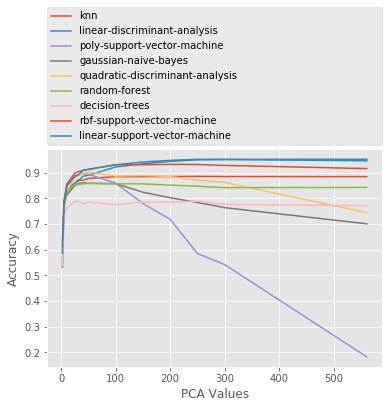

In [89]:
pca()

# Plotting first two PCA components using t-SNE

t-SNE: 219.78 sec


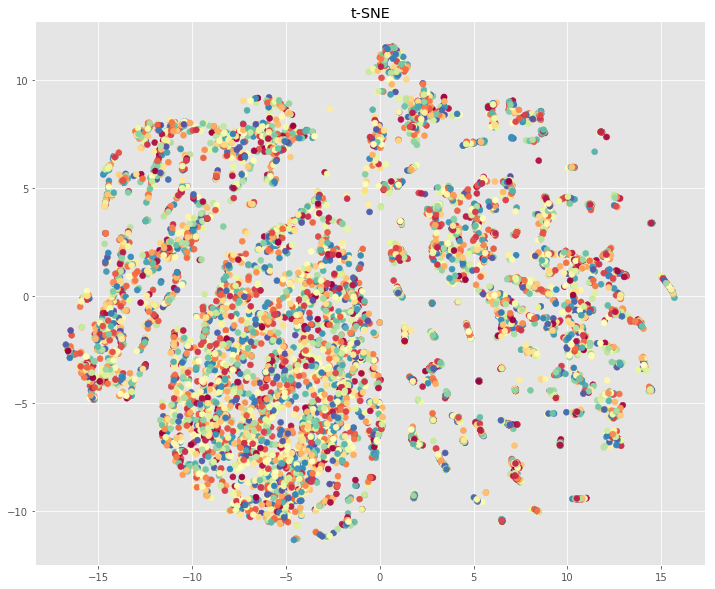

In [90]:
tsne()


# Checking the effect of shuffl/no-shuffe on data without PCA

## Classifier comparision with shuffle

knn done in 0.469s
gaussian-naive-bayes done in 5.858s
quadratic-discriminant-analysis done in 6.025s
linear-discriminant-analysis done in 8.910s
random-forest done in 13.004s
linear-support-vector-machine done in 11.668s
decision-trees done in 19.997s
rbf-support-vector-machine done in 23.498s
poly-support-vector-machine done in 28.541s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.806135,0.747312,0.884883,0.948767,0.951929,0.872865,0.849146,0.887729,0.918090
precision,0.808907,0.793610,0.890326,0.949997,0.952521,0.858405,0.819391,0.889190,0.916479
recall,0.806135,0.747312,0.884883,0.948767,0.951929,0.872865,0.849146,0.887729,0.918090


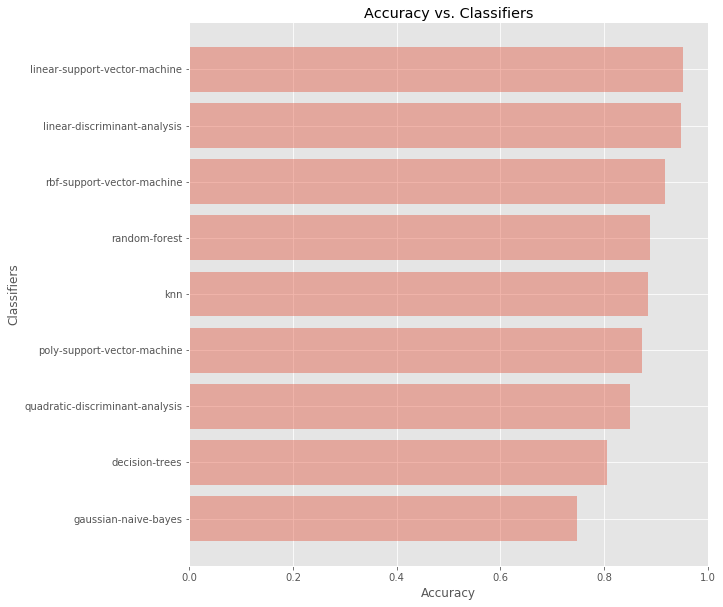

In [91]:
cls_compare_shuff()

## Classifier comparision with  no-shuffle

knn done in 0.345s
gaussian-naive-bayes done in 5.492s
quadratic-discriminant-analysis done in 6.269s
linear-discriminant-analysis done in 10.055s
linear-support-vector-machine done in 11.111s
random-forest done in 12.411s
decision-trees done in 18.984s
rbf-support-vector-machine done in 27.461s
poly-support-vector-machine done in 34.315s


,decision-trees,gaussian-naive-bayes,knn,linear-discriminant-analysis,linear-support-vector-machine,poly-support-vector-machine,quadratic-discriminant-analysis,random-forest,rbf-support-vector-machine
accuracy,0.812460,0.747312,0.884883,0.948767,0.952562,0.867489,0.842821,0.887413,0.916509
precision,0.817406,0.793610,0.890326,0.949997,0.953158,0.872040,0.809106,0.889046,0.918446
recall,0.812460,0.747312,0.884883,0.948767,0.952562,0.867489,0.842821,0.887413,0.916509


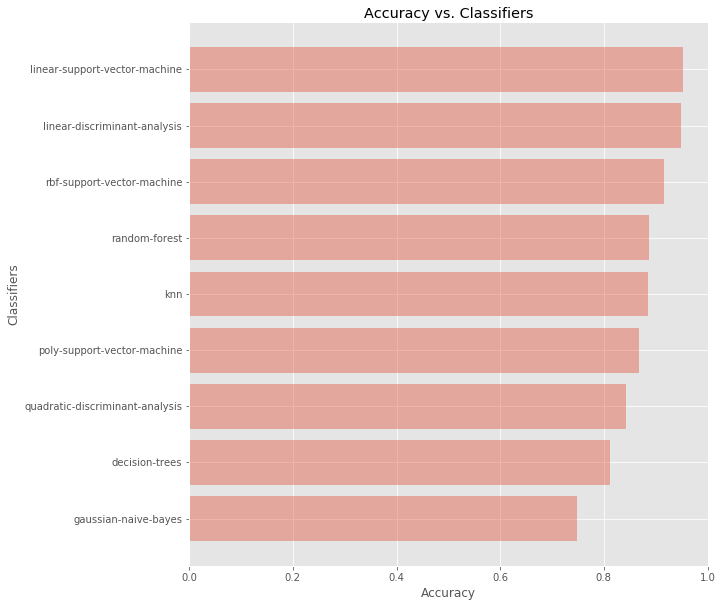

In [92]:

cls_compare_no_shuff()

# SVMs with weighted and un-weighted features

########### Weighted SVM ############
linear-support-vector-machine done in 7.154s
rbf-support-vector-machine done in 21.459s
poly-support-vector-machine done in 29.010s


,linear-support-vector-machine,poly-support-vector-machine,rbf-support-vector-machine
accuracy,0.952562,0.867489,0.916192
precision,0.953158,0.872040,0.918147
recall,0.952562,0.867489,0.916192


########### Unweighted SVM ############
linear-support-vector-machine done in 8.013s
rbf-support-vector-machine done in 22.544s
poly-support-vector-machine done in 28.542s


,linear-support-vector-machine,poly-support-vector-machine,rbf-support-vector-machine
accuracy,0.951929,0.872865,0.918090
precision,0.952521,0.858405,0.916479
recall,0.951929,0.872865,0.918090


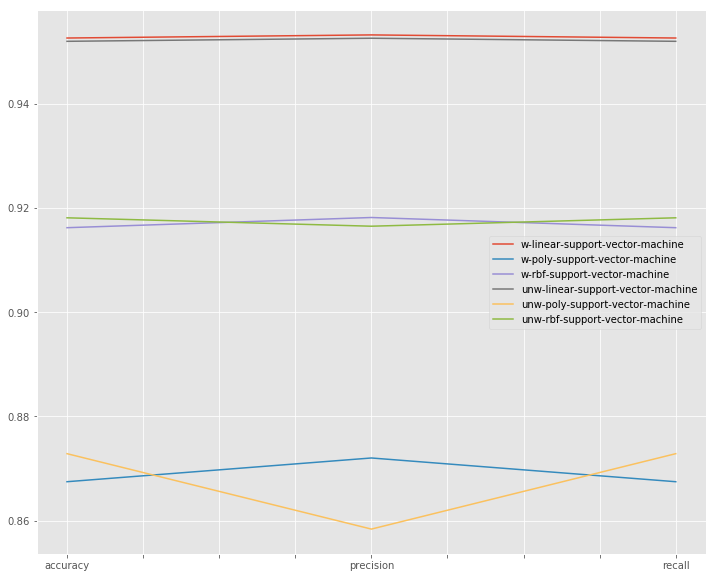

In [93]:
svm_all_weighted_unweighted()

# SVM 'rbf' Kernel with Grid Search

In [96]:
svm_rbf_grid_search()

rbf-support-vector-machine done in 1387.726s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


,rbf-support-vector-machine
accuracy,0.952878
precision,0.953795
recall,0.952878


array([[489,   5,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 15, 455,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  5,  20, 395,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 456,  50,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   9, 547,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 545,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2,   0,   0,  19,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,   4],
       [  0,   0,   0,   2,   0,   2,   0,   0,  10,   0,  35,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   4,  18]])
                    precision    recall  f1-score   support

           WALKING       0.96      0.99      0.97       496
  WALKING_UPSTAIRS       0.94      0.97      0.95 

# SVM 'linear' Kernel with Grid Search 

In [97]:
svm_linear_grid_search()

linear-support-vector-machine done in 84.428s
Best estimator found by grid search:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


,linear-support-vector-machine
accuracy,0.951929
precision,0.952521
recall,0.951929


# Classifier Time Evaluation 

knn done in 0.431s
gaussian-naive-bayes done in 7.083s
quadratic-discriminant-analysis done in 7.817s
linear-discriminant-analysis done in 12.154s
linear-support-vector-machine done in 13.953s
decision-trees done in 20.980s
rbf-support-vector-machine done in 31.242s
poly-support-vector-machine done in 39.730s


,fit_time,pred_time
decision-trees,20.979505,0.006773
gaussian-naive-bayes,7.082532,0.177160
knn,0.430791,23.499083
linear-discriminant-analysis,12.154396,0.011592
linear-support-vector-machine,13.952636,2.823725
poly-support-vector-machine,39.730045,12.669932
quadratic-discriminant-analysis,7.817312,0.453690
rbf-support-vector-machine,31.241865,11.475053


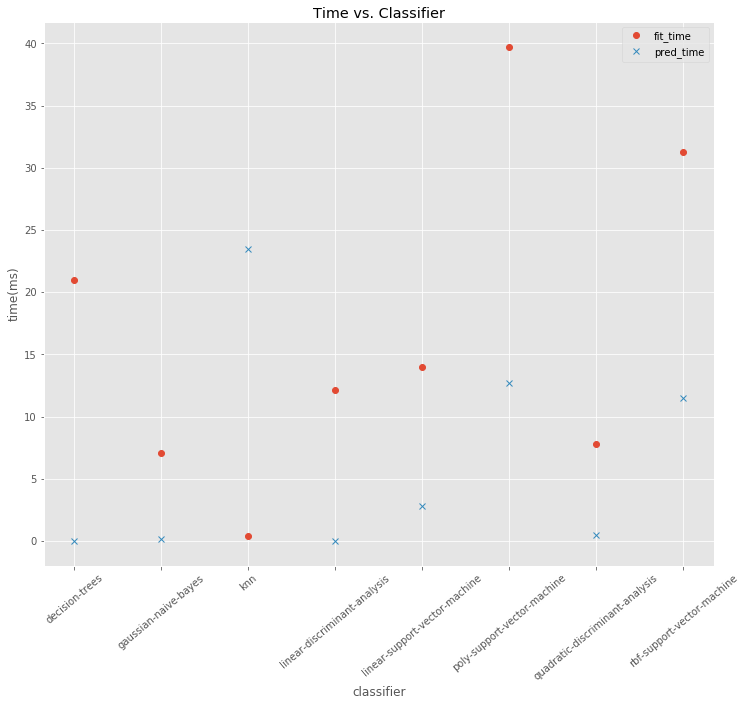

In [2]:
fit_predict_time()